# Segmenting and Clustering Neighborhoods in Toronto
## Part C

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')


In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<font color='Blue'># Keep boroughs with Toronto in their name </font>

In [473]:
geo2 = pd.read_csv(r"C:...\Data\geo2.csv")
geo2.drop(['Unnamed: 0'], axis=1, inplace=True)
Toronto_geo=geo2[geo2['Borough'].str.contains("Toronto")==True]
Toronto_geo.reset_index(drop=True, inplace=True)
Toronto_geo.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


<font color='Blue'># Use geopy library to get the latitude and longitude values of Toronto. </font>

In [394]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<font color='Blue'># create map of Toronto using latitude and longitude valueswith folium </font>

In [397]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_geo['Latitude'], Toronto_geo['Longitude'], Toronto_geo['Borough'], Toronto_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

<font color='Blue'># Define Foursquare Credentials and Version </font> 

In [474]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


<font color='Blue'># make a dataset of all venues in Toronto </font> 

<font color='Green'># add argument of LIMIT to the function below so that we can limit the number of venues </font> 

In [398]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT, radius):
   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<font color='Blue'># Limit the radius to 1000 meters</font>

<font color='Green'># Limit the number of Venues per Neighborhood to 99 units</font> 

In [399]:
Toronto_venues = getNearbyVenues(names=Toronto_geo['Neighborhood'],
                                   latitudes=Toronto_geo['Latitude'],
                                   longitudes=Toronto_geo['Longitude'],
                               LIMIT=99,
                                 radius=1000
                                  )

In [400]:
# Size of Toronto Venues data:
print(Toronto_venues.shape)
Toronto_venues.head()

(3149, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater
2,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery
3,The Beaches,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
4,The Beaches,43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop


In [154]:
#Toronto_venues.groupby('Neighborhood').count()

In [401]:
#### Let's find out how many unique categories can be curated from all the returned venues
print('There are {} unique categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 276 unique categories.


<font color='Blue'># Make a wide format of data with neighborhood in rows and venues in columns</font>

In [402]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Drop the 'Neighborhood column that exists'
Toronto_onehot.drop('Neighborhood', axis=1, inplace=True) 

# Insert Neighborhood column in first column
Toronto_onehot.insert(0, 'Neighborhood', Toronto_venues['Neighborhood'].values)

Toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

<font color='Blue'># group rows by neighborhood and by taking the mean of the frequency of occurrence of each category</font> 

In [404]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

<font color='Blue'># make a data set with neighborhood along with the top 9 most common venues</font> 

In [405]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [417]:
num_top_venues = 12

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,"Adelaide, King, Richmond",Hotel,Café,Coffee Shop,Theater,Restaurant,Sushi Restaurant,Steakhouse,Cosmetics Shop,Beer Bar,Seafood Restaurant,Clothing Store,Pub
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Coffee Shop,Harbor / Marina,Café,Scenic Lookout,Dog Run,Track,Dance Studio,Sculpture Garden,Park,Airport Lounge,Airport,Garden
2,Berczy Park,Coffee Shop,Hotel,Café,Restaurant,Beer Bar,Japanese Restaurant,Park,Bakery,Farmers Market,Steakhouse,Breakfast Spot,BBQ Joint
3,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Bar,Restaurant,Bakery,Furniture / Home Store,Gift Shop,Tibetan Restaurant,Gym,Indian Restaurant,Italian Restaurant,Juice Bar
4,Business Reply Mail Processing Centre 969 Eastern,Park,Coffee Shop,Pizza Place,Brewery,Burrito Place,Italian Restaurant,Sushi Restaurant,Skate Park,French Restaurant,Beach,Fast Food Restaurant,Restaurant


### Cluster Neighborhoods

<font color='Blue'># find optimum number of clusters using WCSS method</font> 

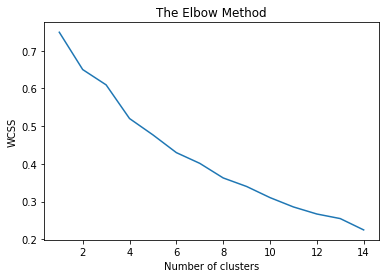

In [418]:
import matplotlib.pyplot as plt
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
wcss = []
for i in range(1, 15):
    
    kmeans = KMeans(n_clusters=i, random_state=500, max_iter=100, n_init=10).fit(Toronto_grouped_clustering)

    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<font color='Blue'># above diagram doesn't help that much, I use 5 clusters. </font>  

In [469]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, max_iter=1000, n_init=50).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 3, 0, 4, 1, 0, 0, 4, 4, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 4, 1, 0,
       1, 1, 2, 4, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1])

In [470]:
# add clustering labels
neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Coffee Shop,Pizza Place,Japanese Restaurant,Breakfast Spot,Beach,Burger Joint,Tea Room,Bar,Bakery,Sandwich Place,Caribbean Restaurant
1,M4K,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Café,Pub,Italian Restaurant,Spa,Fast Food Restaurant,Ramen Restaurant,Pizza Place,Bank,Bakery,Diner
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Indian Restaurant,Coffee Shop,Café,Park,Beach,Grocery Store,Bakery,Restaurant,Fast Food Restaurant,Sandwich Place,Brewery,Burrito Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Bar,Café,Brewery,American Restaurant,Vietnamese Restaurant,Italian Restaurant,Bakery,Diner,French Restaurant,Gym / Fitness Center,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Café,Coffee Shop,College Quad,Trail,Gym / Fitness Center,College Gym,Park,Bookstore,Farm,Farmers Market,Doner Restaurant,Falafel Restaurant


##  Create a map

In [471]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters